In [1]:
#!/usr/bin/env python
import cv2
import matplotlib as mpl
import nbconvert
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.signal
import sys
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn import metrics
%matplotlib inline
import numpy as np
import itertools 
import csv
import scipy.signal
from matplotlib.pyplot import figure
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
DAYINT=1
cameranumint=1
datasetPath='C:/Users/Lucrezia/Desktop/Internship/MNM_version2-Revision17/Mingle/'

In [3]:
#converts a CSV file into an array, returns any array, the array encoded in the CSV file
def openCSV(filename):
    rows = []
    with open(filename) as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            rows.append(row)
    arr = np.array(rows)
    return arr

In [4]:
# reading the file, datasetPath is defined, name is the specific folder
def reading(name):
    try:
        filename = datasetPath+name
        label = openCSV(filename)
    except FileNotFoundError:
        filename = datasetPath+name
        label = openCSV(filename).astype(np.int64)
    except PermissionError:
        label=datasetPath+name
    
    return(label)

In [5]:
#some values in the dataset has strange format, with this function we are sure to transform them in to int
def posiz(stringa):
    try:
        s=int(stringa)
    except ValueError:
        s=float(stringa)
        s=round(s)
        s=int(s)
    return(s)

In [6]:
#If you don't want the text,just comment scv2.putText
#it shows the frame postion of the participants, if their data are NaN or the camera is filming them is different,
#we will append 'out'. 
def showframe(frame,label,camera_num,name,counter2,lista):
    if (label[counter2][5] != 'NaN' or label[counter2][6] != 'NaN') and str(label[counter2][2]) == camera_num :
        cv2.putText(frame, name, (posiz(label[counter2][5])-90,posiz(label[counter2][6])-20), 0, 0.8, (255, 255, 255), 1, cv2.LINE_AA)
        frame = cv2.circle(frame, (posiz(label[counter2][5]),posiz(label[counter2][6])), radius=2, color=(255, 255, 255), thickness=10)
        lista.append((float(label[counter2][5]),float(label[counter2][6]),name))
    else:
        lista.append('out') 
        pass
    return(frame,lista)

In [7]:
#showing the o-spaces
def centrf(frame,counter2,cen):
    for i in cen:
        frame = cv2.circle(frame, (int(i[0]),int(i[1])), radius=60, color=(52, 151, 255), thickness=5)
    return(frame)

In [8]:
#If you don't want the text,just comment scv2.putText
#Showing the center of attentions
def showatt(frame,Cfin,lista):
    lun=len(lista)
    for i in range(0,lun):
        if lista[i]!='out':
            frame = cv2.circle(frame, (int(cbodies[i][0][0]),int(cbodies[i][0][1])), radius=2, color=(128,114,250), thickness=10)
            #frame= cv2.putText(frame, 'CA'+lista[i][1], (int(cbodies[i][0][0])-100,int(cbodies[i][0][1])+4), 0, 0.8, (128,114,250), 1, cv2.LINE_AA)
    return(frame)

In [9]:
#transforming degree to rad, since we will use mainly rad
def degreerad(n):
    return(float(n*np.pi/180.0))

In [10]:
#final angle calculation considering also some specific cases, indeed, we don't have negative angles in the dataset, so 
#if we end up with a negative angle we will consider degreerad(360)-angleatot, same if our final angle is bigger then 360, we
#will consider degreerad(360)-(angleatot-degreerad(360))
def anglecalc(wind,li):
    sin=0
    cos=0
    for i in range(0,wind+1):#+1
        sin+=np.sin(float(li[i]))
        cos+=np.cos(float(li[i]))
    angleatot= np.arctan2(sin,cos)
    if angleatot<0:
        angleatot=degreerad(360)-angleatot
    if angleatot>degreerad(360):
        angleatot=degreerad(360)-(angleatot-degreerad(360))
    return(angleatot)

In [11]:
#We create the final list of angles that depend on the average angle of the body, the average angle of the head and the frequences 
#of torsion in a wind->time window
def finallistangle(a,b,s,wind):
    lis=[]
    for i in range(0,s):
        lis.append(a)
    for i in range(0,(wind+1)-s):
        lis.append(b)
    lisf=anglecalc(wind,np.array(lis))
    return(lisf)

In [12]:
#Calculation of the average angle of the body and angle of the head, only if our participants are not 'out', so if we
#have all the data for the last wind-> time window  frames
def anglestory(i,counter2,anglemem,anglebodymem,angleheadmem,anglebody,anglehead,actual_st,wind):
    if counter2>=wind+1: #and checkf==0 :
        check1=np.count_nonzero(anglemem[-wind:,i]=='out')
        check2=np.count_nonzero(anglebodymem[-wind:,i]=='out')
        check3=np.count_nonzero(angleheadmem[-wind:,i]=='out')
        checkf=check1 or check2 or check3
        if checkf==0 :
            s=np.count_nonzero(anglemem[-wind:,i]=='0')
            a=anglebodymem[-wind:,i]
            a=np.append(a,anglebody)
            b=angleheadmem[-wind:,i]
            b=np.append(b,anglehead)
            atot=anglecalc(wind,a)
            btot=anglecalc(wind,b)
            if actual_st==0:
                s=s
            else: 
                s+=1
            Anglefin=finallistangle(atot,btot,s,wind)
        else:
            Anglefin=anglebody 
    else:
        Anglefin=anglebody  
    return(Anglefin)

In [13]:
#calculation of the center of attention, depending on the average angle of the body, the average angle of the head and the frequences 
#of torsion in a wind->time window
#if we have 'out' or if the alghortim does not has a time window of timewindow , we will use the actual angle of the body
def attentionbody(frame,lista,counter2,anglemem,anglebodymem,angleheadmem):
    timewindow=5 #we need to be aware that in the videos of day one, we don't have data after frame 100, that is second 5. so if we
    #give as input 6, the alghoritm have to wait all the empty frames to pass. This creates many problem, both to the alghortim and 
    #both logically, because after all the NaN the situation is different. For this reason in day one, 5 is the biggest 
    #time window we can reach. If the error in the dataset will be correct, this value may be increased.
    maxtorsion=5
    lun=len(lista)
    cbodies=[]
    r=100 #90
    anglebodyit=[]
    angleheadit=[]
    angleit=[]
    anglemem_arr=np.array(anglemem)
    anglebodymem_arr=np.array(anglebodymem)
    angleheadmem_arr=np.array(angleheadmem)
    for i in range(0,lun):
        if lista[i]!='out':
            anglebody=degreerad(posiz(listalabels[i][counter2][12]))#11 head 12 body
            anglehead=degreerad(posiz(listalabels[i][counter2][11]))#11 head 12 body
            Ctot=[]
            angleheadit.append(anglehead)
            anglebodyit.append(anglebody)
            a = np.abs(anglehead - anglebody)
            if (np.abs((a + degreerad(180)) % degreerad(360) - degreerad(180)))<degreerad(maxtorsion):
                angleit.append(0) 
                anglefin=anglestory(i,counter2,anglemem_arr,anglebodymem_arr,angleheadmem_arr,anglebody,anglehead,0,timewindow-1)

            else:
                angleit.append(1)
                anglefin=anglestory(i,counter2,anglemem_arr,anglebodymem_arr,angleheadmem_arr,anglebody,anglehead,1,timewindow-1)

            Cfin=[posiz(listalabels[i][counter2][5])+r*np.cos(anglefin),posiz(listalabels[i][counter2][6])+r*np.sin(anglefin)]
            cbodies.append([Cfin,lista[i][2]])
        else:
            angleit.append('out')
            angleheadit.append('out')
            anglebodyit.append('out')
    
    anglemem.append(angleit)
    anglebodymem.append(anglebodyit)
    angleheadmem.append(angleheadit)
    if counter2>=timewindow:#cleaning the memory
        anglemem.pop(0)
        anglebodymem.pop(0)
        angleheadmem.pop(0)
    if len(cbodies)==0:
        checkactsit=1
    else:
        checkactsit=0
    return(frame,cbodies,anglemem,anglebodymem,angleheadmem,checkactsit)

In [14]:
#clustering alghoritm
def clust(orient,counter2,cont,ncl,pl=False):
    mpl.style.use('seaborn')
    lst2 = [item[0] for item in orient]
    X = np.array(lst2)#position of centers of attention
    met=[]
    colori=['red','green','yellow','orange','black','purple','brown','pink','gray','olive','cyan','springgreen','lightsalmon','plum']
    if cont==0:
        for i in range(2,len(X)):#first iteration between 2 and the total number of people identified in that moment in the room
            kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
            labels=kmeans.labels_
            met.append(metrics.silhouette_score(X, labels, metric='euclidean'))#we append all results
        massimo=max(met)#find the highest one
        counter=2
        s=0
        for j in met:
            if j==massimo:
                s=counter #find in which iteration it was
                counter+=1
            else:
                counter+=1
    else: #after the first frame, we only  between  ncl-1 and ncl+2, if our actual class is 2, we will iterate between 2 and ncl+2. 
        if ncl==2:
            ncl1=ncl
        else:
            ncl1=ncl-1
        for i in range(ncl1,ncl+2):
            kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
            labels=kmeans.labels_
            if (labels.size - np.count_nonzero(labels))==labels.size:
                met.append(0)
            else:
                met.append(metrics.silhouette_score(X, labels, metric='euclidean'))     
        massimo=max(met)
        counter=ncl-1#ncl-1
        s=0
        for j in met:
            if j==massimo:
                s=counter
                counter+=1
            else:
                counter+=1
    
    kmeans = KMeans(n_clusters=s, random_state=0).fit(X)
    labels=kmeans.labels_
    peopleclust=[]
    for j in range(0,len(X)):
        peopleclust.append([orient[j][1],labels[j]]) 
        if pl==True:
            plt.scatter(X[kmeans.labels_==j,0],X[kmeans.labels_==j,1],c=colori[j],s=31)    
    if pl==True:
        plt.gca().invert_yaxis()
        plt.xlabel('frame width')
        plt.ylabel('frame height')
        plt.savefig('clusteringprova'+str(counter2)+'.png')
        plt.show()
    return(kmeans.cluster_centers_,s,peopleclust)

In [15]:
#saving interaction each frame, do in momentanea, we have the nuber of cluster and the participants of one f-form,
# in totale for all the interaction find in one frame
def data(counter2,ncl,peopleclust):
    totale=[]
    totale.append(counter2)
    for m in range(0,ncl):
        momentanea=[]
        momentanea.append(m)
        f_fcer=[]
        for i in peopleclust:
            if i[1]==m:
                f_fcer.append(i[0])
        momentanea.append(f_fcer)
        totale.append(momentanea)
    return(totale)

In [16]:
#construction of the actual memory matrix, based on actual f-formation, 1 if present 0 if not
def matrice(mom):
    mat=np.zeros((32,32))
    for i in range(1,len(mom)):
        x=len(mom[i][1])
        li=[]
        for j in range(0,x):
            if 'person' in mom[i][1][j]:
                li.append(int((mom[i][1][j].replace('person',''))))
        c = list(itertools.combinations(li, 2))
        for m in c:
            mat[m[0]-1,m[1]-1]=1
            mat[m[1]-1,m[0]-1]=1
    return(mat)

In [17]:
#analysis of the final memory matrix
def analysis(totale,a,prec,cont0,cont1):
    t=len(totale)
    temp=np.arange(0,t)
    x=[]
    for i in range(0,t):
        c = list(itertools.combinations(a, 2))#in we want to check between a group of three
        listamom=[]
        for j in c:
            if totale[i][j[0]-1][j[1]-1]==1:
                listamom.append(1)
            else:
                listamom.append(0)
        s0=listamom.count(0)
        if s0!=0:
            if prec==0:
                if cont0>2:
                    x.append(0) #precedent is 0 in for more than 60 frames->no more f-form 
                else:
                    x.append(0.2) #precedent is 0 in for already 20-40 frames 
            else:
                x.append(0.5) #precent is 1, maybe just an error 
            prec=0
            cont0+=1
            cont1-=1
            if cont0>5:
                cont0=5
            if cont1<0:
                cont1=0
        else: 
            if prec==1:
                if cont1>2:
                    x.append(1) #precedent is  1 in for more than 60 frames-> f-form
                else:
                    x.append(0.8) #precedent is  1 in for already 20-40 frames 
            else:
                x.append(0.5) #precent is 0, maybe just an error 
            prec=1
            cont1+=1
            cont0-=1
            if cont1>5:
                cont1=5
            if cont0<0:
                cont0=0
        
    #print(len(x))
    figure(figsize=(10, 6))
    plt.plot(temp,x)
    tit=str(a)
    plt.xlabel('Time',fontsize=20)
    plt.ylabel('Engagement',fontsize=20)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.title('Engadgment in the F-formation between persons %s' %tit)
    plt.show()
    
    return(temp,x,tit)

In [18]:
#analysis of the distances in each frame, if the data were not NaN, of a group or a couple. 
def analysisdist(totale,a,listalabels,pl=False):
    t=len(totale)
    x=[]
    c = list(itertools.combinations(a, 2))#in we want to check between a group of three
    for j in c:
        temp=[]
        num=0
        dist=[]
        for i in range(0,t-1):
            if listalabels[j[0]-1][i+1][5]!= 'NaN' and listalabels[j[0]-1][i+1][6]!= 'NaN' and listalabels[j[1]-1][i+1][5]!= 'NaN' and listalabels[j[1]-1][i+1][6]!= 'NaN':
                d=(posiz(listalabels[j[0]-1][i+1][5]),posiz(listalabels[j[0]-1][i+1][6]))
                b=(posiz(listalabels[j[1]-1][i+1][5]),posiz(listalabels[j[1]-1][i+1][6]))
                dist.append(distance.euclidean(d, b))
                num+=1
                temp.append(num) 
        fig=plt.figure()
        if pl==True:
             plt.figure(figsize=(10, 6))
        plt.plot(temp,dist)
        tit=str(a)
        #plt.title('Distance in the F-formation between persons %s' %str(j))
        ttl='Distanceepersons17000'+ str(j)+'.png'
        plt.xlabel('Time',fontsize=20)
        plt.ylabel('Distance',fontsize=20)
        plt.xticks(fontsize=17)
        plt.yticks(fontsize=17)
        plt.savefig(ttl,bbox='tight_layout',dpi=100)
        if pl==True:
            plt.show()
        else:
            plt.close(fig)
    return(0)
    

In [19]:
#analysis of the reciprocal angle in each frame, if the data were not NaN, of a group or a couple. 
def analysisangle(totale,a,listalabels,pl=False):
    t=len(totale)
    x=[]
    distmed=[]
    c = list(itertools.combinations(a, 2))#in we want to check between a group of three
    for j in c:
        temp=[]
        angle=[]
        num=0
        for i in range(0,t-1):
            if listalabels[j[0]-1][i+1][5]!= 'NaN' and listalabels[j[0]-1][i+1][6]!= 'NaN' and listalabels[j[1]-1][i+1][5]!= 'NaN' and listalabels[j[1]-1][i+1][6]!= 'NaN' and listalabels[j[1]-1][i+1][12]!= 'NaN' and listalabels[j[0]-1][i+1][12]!= 'NaN':
                point1=(posiz(listalabels[j[0]-1][i+1][5]),posiz(listalabels[j[0]-1][i+1][6]))
                point2=(posiz(listalabels[j[1]-1][i+1][5]),posiz(listalabels[j[1]-1][i+1][6]))
                v=np.array([point2[0]-point1[0],point2[1]-point1[1]])
                v=v/np.linalg.norm(v)
                alpha=degreerad(float(listalabels[j[0]-1][i+1][12]))
                beta=degreerad(float(listalabels[j[1]-1][i+1][12]))
                u1=np.array([np.cos(alpha),np.sin(alpha)])
                u2=np.array([np.cos(beta),np.sin(beta)])
                angletot=np.arccos(np.dot(v,u1))+np.arccos(np.dot(-v,u2))
                angle.append((angletot*180)/np.pi)
                num+=1
                temp.append(num) 
        
        fig=plt.figure()
        if pl==True:
             plt.figure(figsize=(10, 6))
        plt.plot(temp,angle)
        tit=str(a)
        #plt.title('Total rotation required in the F-formation to face each other %s' %str(j),fontsize=20)
        ttl='Anglepersons17000'+ str(j)+'.png'
        plt.xlabel('Time',fontsize=20)
        plt.ylabel('Angle in degree',fontsize=20)
        plt.xticks(fontsize=17)
        plt.yticks(fontsize=17)
        plt.savefig(ttl,bbox='tight_layout',dpi=100)
        if pl==True:
            plt.show()
        else:
            plt.close(fig)
    return(0)

In [20]:
#Creation of a csv that save all the interaction of person p1.
def fformwithwho(p1,totale):
    spi=str(p1)
    with open('fformof'+spi+'.csv', 'w',newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Frame", "Person"])
        for i in range(0,len(totale)):
            mom=[]
            for j in range(0,len(totale[0])):
                if totale[i][j][p1-1]==1:
                    mom.append(j+1)  
            writer.writerow([i,mom])

In [21]:
#This function is used to see the difference in the result of the center of attention of person 'person', 
#with respect tot the one calculated with the time-averaged angle.
def checkontheangle(frame,person,listalabels,count):
    a=degreerad(posiz(listalabels[person-1][count][12]))
    Cfin=[posiz(listalabels[person-1][count][5])+100*np.cos(a),posiz(listalabels[person-1][count][6])+100*np.sin(a)]
    frame = cv2.circle(frame, (int(Cfin[0]),int(Cfin[1])), radius=2, color=(0, 255, 0), thickness=10)

    return(frame)

In [22]:
DAY=str(DAYINT)
cameranum=str(cameranumint)
#1->32
#2->30
#3->30

count=0
datasetPath1=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY)
for path in os.listdir(datasetPath1):
    # check if current path is a file
    if os.path.isfile(os.path.join(datasetPath1, path)):
        count += 1
print('File count:', count)
#reading and saving all files of each person
labels1=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person1.csv')
labels2=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person2.csv')
labels3=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person3.csv')
labels4=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person4.csv')
labels5=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person5.csv')
labels6=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person6.csv')
labels7=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person7.csv')
labels8=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person8.csv')
labels9=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person9.csv')
labels10=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person10.csv')
labels11=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person11.csv')
labels12=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person12.csv')
labels13=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person13.csv')
labels14=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person14.csv')
labels15=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person15.csv')
labels16=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person16.csv')
labels17=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person17.csv')
labels18=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person18.csv')
labels19=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person19.csv')
labels20=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person20.csv')
labels21=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person21.csv')
labels22=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person22.csv')
labels23=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person23.csv')
labels24=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person24.csv')
labels25=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person25.csv')
labels26=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person26.csv')
labels27=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person27.csv')
labels28=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person28.csv')
labels29=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person29.csv')
labels30=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person30.csv')
if count==32: 
    labels31=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person31.csv')
    labels32=reading('manual_annotations/AdditionalAnnotations/keypointsAndOrientations/day'+DAY+'/person32.csv')
#appending everything 
listalabels=[]
listalabels.append(labels1)
listalabels.append(labels2)
listalabels.append(labels3)
listalabels.append(labels4)
listalabels.append(labels5)
listalabels.append(labels6)
listalabels.append(labels7)
listalabels.append(labels8)
listalabels.append(labels9)
listalabels.append(labels10)
listalabels.append(labels11)
listalabels.append(labels12)
listalabels.append(labels13)
listalabels.append(labels14)
listalabels.append(labels15)
listalabels.append(labels16)
listalabels.append(labels17)
listalabels.append(labels18)
listalabels.append(labels19)
listalabels.append(labels20)
listalabels.append(labels21)
listalabels.append(labels22)
listalabels.append(labels23)
listalabels.append(labels24)
listalabels.append(labels25)
listalabels.append(labels26)
listalabels.append(labels27)
listalabels.append(labels28)
listalabels.append(labels29)
listalabels.append(labels30)
if count==32:
    listalabels.append(labels31)
    listalabels.append(labels32)

File count: 32


960
540
total time:  402.9064450263977


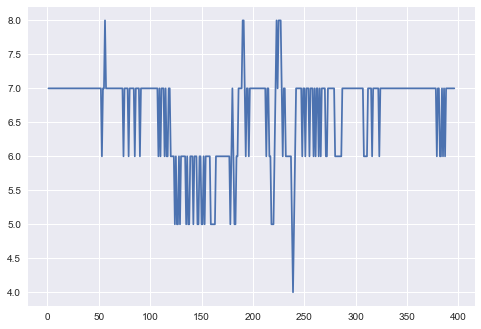

In [23]:
cap = cv2.VideoCapture(datasetPath+'videos/downsample/30min_day'+DAY+'_cam'+cameranum+'_20fps_960x540.mp4')
tempo=[]
totale=[]
totalnumberfform=[]
allcenter=[]
seconds = time.time()
counter=0
counter2=0
memory=[]
frame_w=int(cap.get(3))
frame_h=int(cap.get(4))
print(frame_w)
print(frame_h)
outvideo = cv2.VideoWriter('fformdetection.mp4',cv2.VideoWriter_fourcc('M','P','4','V'), 25, (frame_w,frame_h))
#height=540, width=960
conclu=0
ncl=0
prevcenter=[]
anglemem=[]
anglebodymem=[]
angleheadmem=[]
while cap.isOpened() and counter2<1800:
    ret, frame = cap.read()
    N,M=frame.shape[:2]
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    counter+=1
    if (counter-1)%20==0:
        counter2+=1 
    lista=[]
    #we save all the data for each frame 
    frame,lista=showframe(frame,labels1,cameranum,'person1',counter2,lista)
    frame,lista=showframe(frame,labels2,cameranum,'person2',counter2,lista)
    frame,lista=showframe(frame,labels3,cameranum,'person3',counter2,lista)
    frame,lista=showframe(frame,labels4,cameranum,'person4',counter2,lista)
    frame,lista=showframe(frame,labels5,cameranum,'person5',counter2,lista)
    frame,lista=showframe(frame,labels6,cameranum,'person6',counter2,lista)
    frame,lista=showframe(frame,labels7,cameranum,'person7',counter2,lista)
    frame,lista=showframe(frame,labels8,cameranum,'person8',counter2,lista)
    frame,lista=showframe(frame,labels9,cameranum,'person9',counter2,lista)
    frame,lista=showframe(frame,labels10,cameranum,'person10',counter2,lista)
    frame,lista=showframe(frame,labels11,cameranum,'person11',counter2,lista)
    frame,lista=showframe(frame,labels12,cameranum,'person12',counter2,lista)
    frame,lista=showframe(frame,labels13,cameranum,'person13',counter2,lista)
    frame,lista=showframe(frame,labels14,cameranum,'person14',counter2,lista)
    frame,lista=showframe(frame,labels15,cameranum,'person15',counter2,lista)
    frame,lista=showframe(frame,labels16,cameranum,'person16',counter2,lista)
    frame,lista=showframe(frame,labels17,cameranum,'person17',counter2,lista)
    frame,lista=showframe(frame,labels18,cameranum,'person18',counter2,lista)
    frame,lista=showframe(frame,labels19,cameranum,'person19',counter2,lista)
    frame,lista=showframe(frame,labels20,cameranum,'person20',counter2,lista)
    frame,lista=showframe(frame,labels21,cameranum,'person21',counter2,lista)
    frame,lista=showframe(frame,labels22,cameranum,'person22',counter2,lista)
    frame,lista=showframe(frame,labels23,cameranum,'person23',counter2,lista)
    frame,lista=showframe(frame,labels24,cameranum,'person24',counter2,lista)
    frame,lista=showframe(frame,labels25,cameranum,'person25',counter2,lista)
    frame,lista=showframe(frame,labels26,cameranum,'person26',counter2,lista)
    frame,lista=showframe(frame,labels27,cameranum,'person27',counter2,lista)
    frame,lista=showframe(frame,labels28,cameranum,'person28',counter2,lista)
    frame,lista=showframe(frame,labels29,cameranum,'person29',counter2,lista)
    frame,lista=showframe(frame,labels30,cameranum,'person30',counter2,lista)
    if count==32:
        frame,lista=showframe(frame,labels31,cameranum,'person31',counter2,lista)
        frame,lista=showframe(frame,labels32,cameranum,'person32',counter2,lista)
    
    cv2.putText(frame, 'frame: %d' % counter, (50, 50), 0, 0.8, (6, 0, 210), 2, cv2.LINE_AA)
    #every 20 frame, cause the labels are given in this way
    if (counter-1)%20==0:#since we have the data every 20 frame
        frame,cbodies,anglemem,anglebodymem,angleheadmem,checkactualsit=attentionbody(frame,lista,counter2,anglemem,anglebodymem,angleheadmem)
        if checkactualsit==0: # in attentionbody, if we don't have the data this will be 0, so we will use k-means with no time information
            centr,ncl,peopleclust=clust(cbodies,counter2,conclu,ncl,False)#clustering, True if we want to show and save the plot, otherwise False
            tempo.append(counter2)
            prevcenter = centr
            totalnumberfform.append(ncl)
            mom=data(counter2,ncl,peopleclust)#saving the actual interaction
            mat=matrice(mom) #creating the matrix of interaction in this frame
            totale.append(mat) #adding the actual matrix in the final one
            conclu=1
        else:
            conclu=0
    if checkactualsit==0:
        nan=1
        frame=showatt(frame,lista,cbodies)
        
        #frame=checkontheangle(frame,10,listalabels,counter2) #you can check the center of attention of one persone using the torso angle
        frame=centrf(frame,counter2,centr)#show the f-formation 
    else:
        frame=cv2.putText(frame, 'All data are NaN', (390,270), 0, 0.8, (250, 250, 250), 4, cv2.LINE_AA)
    cv2.imshow('frame', frame)
    outvideo.write(frame)
    if cv2.waitKey(10) == ord('q'):
        break
    if cv2.waitKey(10) == ord('p'):
        cv2.waitKey(-1) 
    else: 
        #conclu=0 # if you scomment this you can see the result using no time information in the K-Means clustering 
        pass
seconds2 = time.time()
print('total time: ',seconds2-seconds)
plt.plot(tempo,totalnumberfform)
plt.show()
cap.release()
outvideo.release()
cv2.destroyAllWindows()

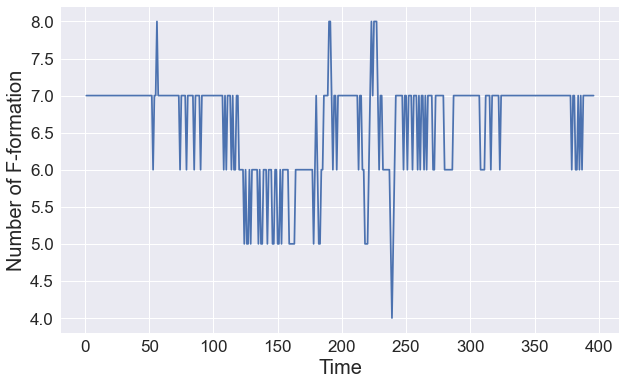

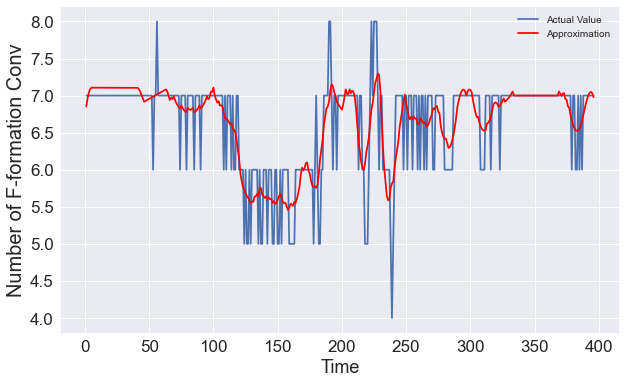

In [24]:
#Total number of F-Formations analysis
figure(figsize=(10, 6))

plt.xlabel('Time',fontsize=20)
plt.ylabel('Number of F-formation',fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.plot(tempo,totalnumberfform)
plt.savefig('NumberofFform1700sb',bbox='tight_layout',dpi=100)
plt.show()

figure(figsize=(10, 6))

plt.xlabel('Time')
plt.ylabel('Number of F-formation')
plt.plot(tempo,totalnumberfform)
plt.savefig('NumberofFform',bbox='tight_layout',dpi=100)
yhat = scipy.signal.savgol_filter(totalnumberfform,21,3)# convolution, polynom of 3rd degree, window of 21 samples
plt.plot(tempo, yhat, color='red')
plt.xlabel('Time',fontsize=18)
plt.ylabel('Number of F-formation Conv',fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(['Actual Value', 'Approximation'])
plt.savefig('NumberofFforsb'+'conv',bbox='tight_layout',dpi=100)
plt.show()

In [30]:
#Distance analysis, insert True to see and save the plots
a=[10,25]#[13,8]#[10,25]#[9,31,28]#[2,14,18]#[13,8]#[10,25]
analysisdist(totale,a,listalabels,False)

0

In [33]:
#Angle analysis, insert True to see and save the plots
a=[9,28]#[2,14]#[9,31]#[10,25]#[13,8]#[9,31,28]#[2,14,18]
analysisangle(totale,a,listalabels,False)

0

<Figure size 720x432 with 0 Axes>

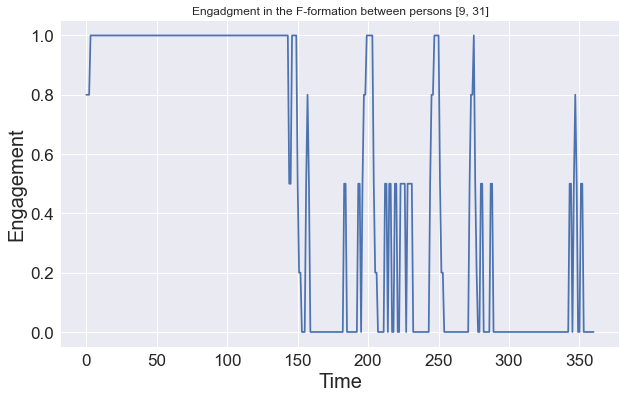

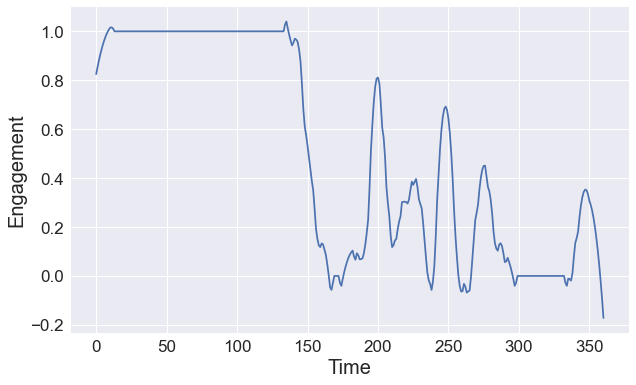

In [25]:
#Engadgment number of F-Formations analysis
a= [9,31]
#a=[10,25]
#a=[28,9]
#a=[2,14]
prec=1
cont1=0
cont0=0
figure(figsize=(10, 6))
temp,x,tit=analysis(totale,a,prec,cont0,cont1) #no convolution
yhat = scipy.signal.savgol_filter(x,21,2) # convolution, polynom of 2nd degree, window of 21 samples

figure(figsize=(10, 6))
#plt.title('Engagment in the F-formation between persons %s' %tit)
plt.xlabel('Time',fontsize=20)
plt.ylabel('Engagement',fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(['Actual Value', 'Approximation'])
#plt.plot(temp,x)
plt.plot(temp, yhat)# color='red'
plt.savefig('Engagment'+str(a)+'onlyconv',bbox='tight_layout',dpi=100)

In [ ]:
#if we want to check in which frame two persons were no in the same f-form, to check manually
#in the video if it's true or it's a dataset error
p1=25
p2=10
for i in range(len(totale)):
    if totale[i][a-1][b-1]<1:
        print(i)

In [37]:
#calculate average angle or distance in determined period of time 
sum1=0
cont=0
for i in range(700,t):
    try:
        an[i]=int(an[i])
        sum1+=an[i]
    except ValueError:
        cont+=1
final1=sum1/(t-700-cont) #(t-cont)
print(final1)

78.88851351351352


In [26]:
fformwithwho(9,totale)